In [1]:
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.metrics import confusion_matrix, accuracy_score,recall_score, precision_score
from sklearn.model_selection import train_test_split

# Common imports
import numpy as np
import os, time
import pandas as pd

# Deep Learning imports
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader,  TensorDataset

import torchvision
import torchvision.transforms as transforms

# To plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', dpi=100)
import seaborn as sns; sns.set()

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [3]:
# Display critical information about the dataset
print("Train set:")
print("Number of images:", train_images.shape[0])
print("Dimensions of the images:", train_images.shape[1:])
print("Max value of images:", np.max(train_images))
print("Min value of images:", np.min(train_images))
print("Test set:")
print("Number of images:", test_images.shape[0])
print("Dimensions of the images:", test_images.shape[1:])
print("Max value of images:", np.max(test_images))
print("Min value of images:", np.min(test_images))

Train set:
Number of images: 50000
Dimensions of the images: (32, 32, 3)
Max value of images: 255
Min value of images: 0
Test set:
Number of images: 10000
Dimensions of the images: (32, 32, 3)
Max value of images: 255
Min value of images: 0


In [4]:
# Check for NaN values
if np.isnan(train_images).any() or np.isnan(test_images).any():
    print("There are NaN values in the dataset.")
else:
    print("There are no NaN values in the dataset.")


There are no NaN values in the dataset.


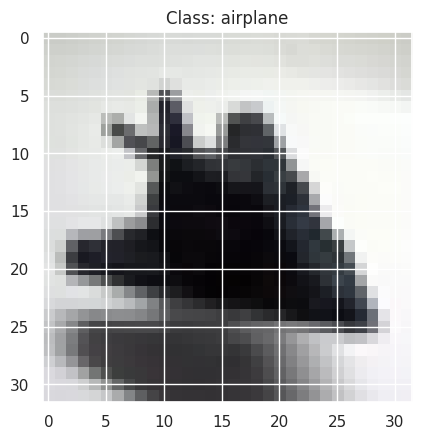

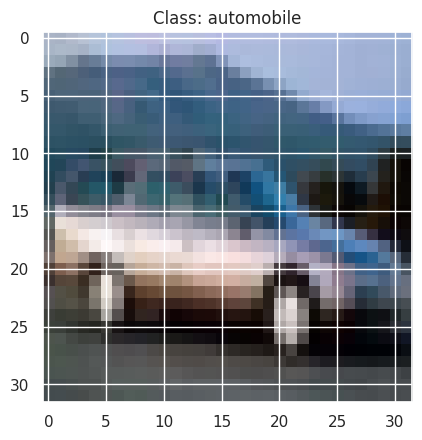

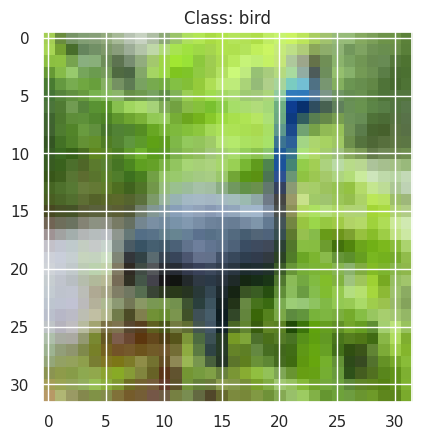

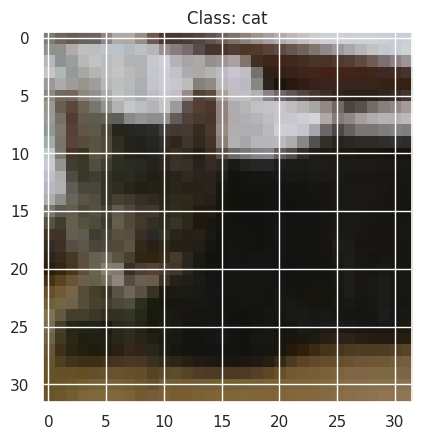

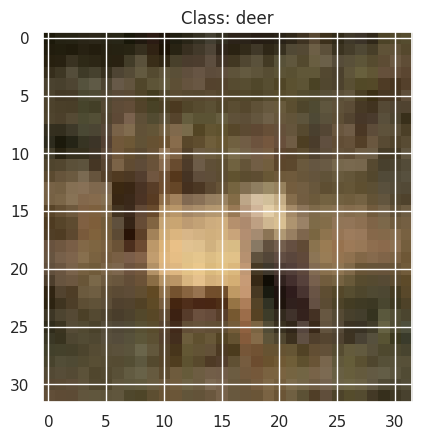

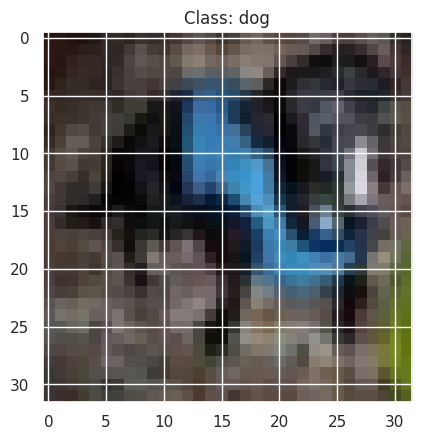

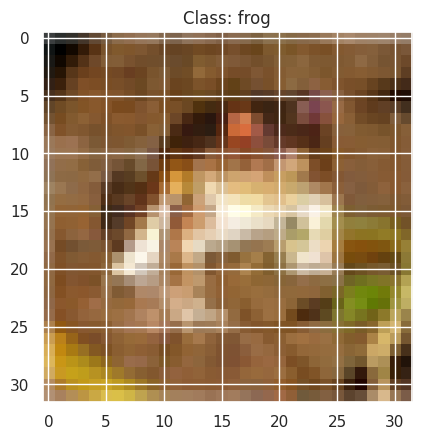

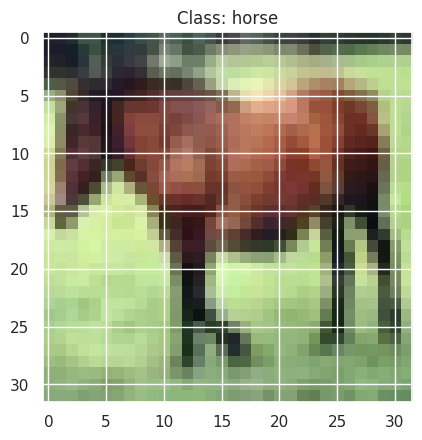

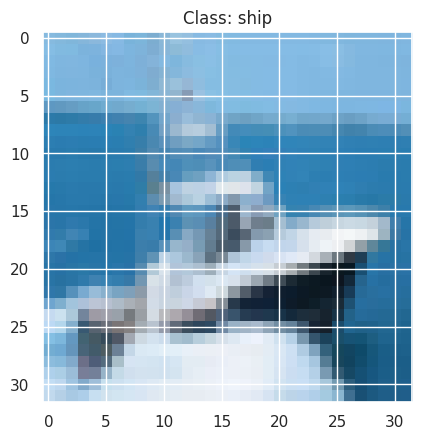

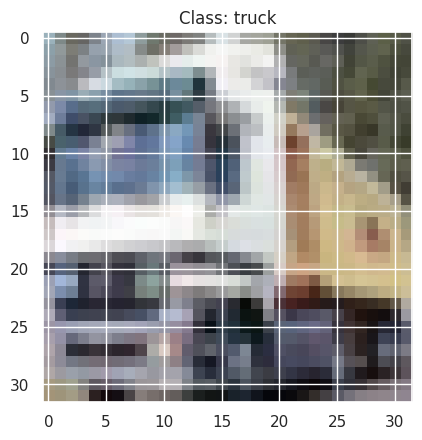

In [5]:
# Display a single image from each class in the train dataset
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]
unique_classes = np.unique(train_labels)
for class_id in unique_classes:
    image_index = np.where(train_labels == class_id)[0][0]
    plt.figure()
    plt.imshow(train_images[image_index])
    plt.title(f"Class: {class_names[class_id]}")
    plt.show()

In [6]:
# Check the balance of classes in the train and test datasets
train_class_counts = [len(np.where(train_labels == class_id)[0]) for class_id in unique_classes]
test_class_counts = [len(np.where(test_labels == class_id)[0]) for class_id in unique_classes]

for class_id, class_name in enumerate(class_names):
    print(f"Class {class_name}")
    print(f"Train : {train_class_counts[class_id]} samples")
    print(f"Test: {test_class_counts[class_id]} samples\n")

Class airplane
Train : 5000 samples
Test: 1000 samples

Class automobile
Train : 5000 samples
Test: 1000 samples

Class bird
Train : 5000 samples
Test: 1000 samples

Class cat
Train : 5000 samples
Test: 1000 samples

Class deer
Train : 5000 samples
Test: 1000 samples

Class dog
Train : 5000 samples
Test: 1000 samples

Class frog
Train : 5000 samples
Test: 1000 samples

Class horse
Train : 5000 samples
Test: 1000 samples

Class ship
Train : 5000 samples
Test: 1000 samples

Class truck
Train : 5000 samples
Test: 1000 samples



In [7]:
# Split the training dataset into training and validation sets with stratification
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, stratify=train_labels, random_state=42
)

# Display the shapes of the new datasets
print("Training set shape:", train_images.shape)
print("Validation set shape:", val_images.shape)
print()

# Check the balance of classes in the new training and validation datasets
train_class_counts = [len(np.where(train_labels == class_id)[0]) for class_id in np.unique(train_labels)]
val_class_counts = [len(np.where(val_labels == class_id)[0]) for class_id in np.unique(val_labels)]

for class_id, class_name in enumerate(class_names):
    print(f"Class {class_name}")
    print(f"Training: {train_class_counts[class_id]} samples")
    print(f"Validation: {val_class_counts[class_id]} samples\n")

Training set shape: (40000, 32, 32, 3)
Validation set shape: (10000, 32, 32, 3)

Class airplane
Training: 4000 samples
Validation: 1000 samples

Class automobile
Training: 4000 samples
Validation: 1000 samples

Class bird
Training: 4000 samples
Validation: 1000 samples

Class cat
Training: 4000 samples
Validation: 1000 samples

Class deer
Training: 4000 samples
Validation: 1000 samples

Class dog
Training: 4000 samples
Validation: 1000 samples

Class frog
Training: 4000 samples
Validation: 1000 samples

Class horse
Training: 4000 samples
Validation: 1000 samples

Class ship
Training: 4000 samples
Validation: 1000 samples

Class truck
Training: 4000 samples
Validation: 1000 samples



In [8]:
X_train, X_val, X_test = train_images/255.0, val_images/255.0, test_images/255.0
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(train_labels.shape)
print(test_labels.shape)
print(val_labels.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)
(40000, 1)
(10000, 1)
(10000, 1)


In [9]:
from sklearn.utils.multiclass import unique_labels

# Evaluating model with loss, accuracy, precision an recall
def evaluate_model_cnn(model, X_val, y_val):
    loss, accuracy = model.evaluate(X_val, y_val)

    # Make predictions
    y_pred = model.predict(X_val)
    y_pred_class = np.argmax(y_pred, axis=1)

    precision = precision_score(y_val, y_pred_class,average='macro',zero_division=0.0)
    recall = recall_score(y_val, y_pred_class, average='macro',zero_division=0.0)

    return loss, accuracy, precision, recall

def metrics(model, test_data, test_labels ):

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_class = np.argmax(y_pred, axis=1)

    precision = precision_score(test_labels, y_pred_class,average='macro',zero_division=0.0)
    recall = recall_score(test_labels, y_pred_class, average='macro',zero_division=0.0)
    accuracy = accuracy_score(test_labels,y_pred_class)

    return accuracy, precision, recall


def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [10]:
from tensorflow.keras import layers, models
# General baseline model
def baseline_cnn(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    return model

In [ ]:
model = baseline_cnn((32, 32, 3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
def train_model_cnn(model, X_train, y_train, X_val, y_val, epochs=10, batch_size=32):
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_val, y_val))
    return model, history

Epoch 1/100
1250/1250 [==============================] - 9s 6ms/step - loss: 1.6085 - accuracy: 0.4053 - val_loss: 1.4219 - val_accuracy: 0.4785
Epoch 2/100
1250/1250 [==============================] - 7s 5ms/step - loss: 1.2613 - accuracy: 0.5508 - val_loss: 1.1504 - val_accuracy: 0.5938
Epoch 3/100
1250/1250 [==============================] - 6s 5ms/step - loss: 1.1025 - accuracy: 0.6087 - val_loss: 1.0956 - val_accuracy: 0.6093
Epoch 4/100
1250/1250 [==============================] - 7s 6ms/step - loss: 1.0058 - accuracy: 0.6431 - val_loss: 1.0309 - val_accuracy: 0.6381
Epoch 5/100
1250/1250 [==============================] - 7s 5ms/step - loss: 0.9308 - accuracy: 0.6731 - val_loss: 0.9938 - val_accuracy: 0.6493
Epoch 6/100
1250/1250 [==============================] - 7s 5ms/step - loss: 0.8745 - accuracy: 0.6939 - val_loss: 0.9329 - val_accuracy: 0.6720
Epoch 7/100
1250/1250 [==============================] - 6s 5ms/step - loss: 0.8179 - accuracy: 0.7122 - val_loss: 0.9350 - val_ac

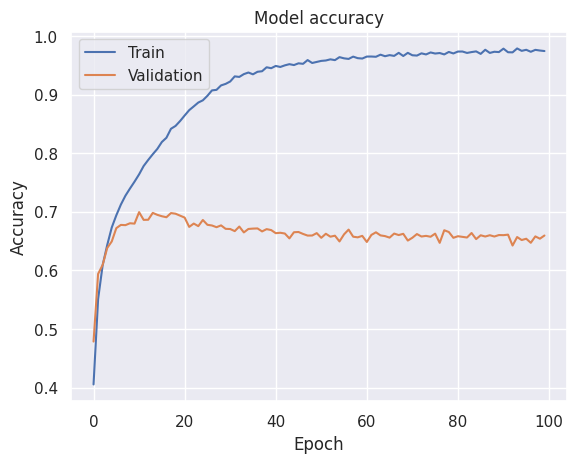

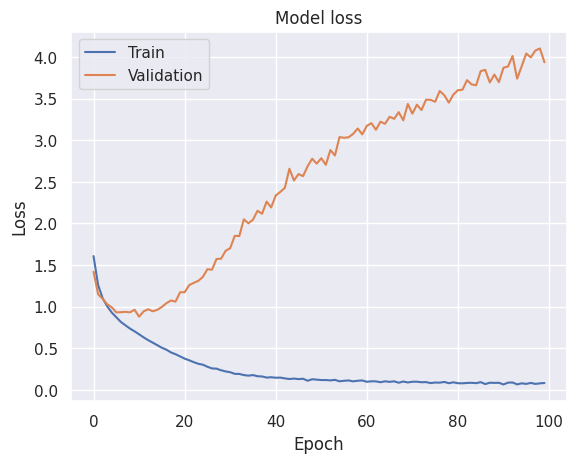

In [ ]:
model, history = train_model_cnn(model, X_train, train_labels, X_val, val_labels, epochs=100, batch_size=32)
plot_training_history(history)

In [ ]:
# Performance on validation set
loss, accuracy, precision, recall= evaluate_model_cnn(model, X_val, val_labels)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

313/313 [==============================] - 1s 4ms/step
Loss: 3.9359421730041504
Accuracy: 0.6593999862670898
Precision: 0.6633448622064406
Recall: 0.6594


In [ ]:
# Performance on test set
accuracy, precision, recall = metrics(model, X_test, test_labels)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

313/313 [==============================] - 1s 3ms/step
Accuracy: 0.6563
Precision: 0.6592031894399866
Recall: 0.6563000000000001


In [12]:
# Creating a Dense CNN
def create_dense_model(learning_rate, num_filters, hidden_sizes):
    model = models.Sequential()
    for filter in num_filters:
        model.add(layers.Conv2D(filter, (3, 3), activation='relu', input_shape=(32, 32, 3),padding='same'))
        model.add(layers.MaxPooling2D((2, 2),padding='same'))

    model.add(layers.Flatten())

    for hidden_size in hidden_sizes[1:-1]:
        model.add(layers.Dense(hidden_size, activation='relu'))
    model.add(layers.Dense(hidden_sizes[-1], activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model



Epoch 1/100
1250/1250 [==============================] - 11s 7ms/step - loss: 1.7564 - accuracy: 0.3142 - val_loss: 1.4551 - val_accuracy: 0.4458
Epoch 2/100
1250/1250 [==============================] - 8s 6ms/step - loss: 1.3117 - accuracy: 0.5150 - val_loss: 1.1737 - val_accuracy: 0.5765
Epoch 3/100
1250/1250 [==============================] - 8s 7ms/step - loss: 1.0886 - accuracy: 0.6085 - val_loss: 1.1075 - val_accuracy: 0.6036
Epoch 4/100
1250/1250 [==============================] - 8s 7ms/step - loss: 0.9497 - accuracy: 0.6640 - val_loss: 1.0334 - val_accuracy: 0.6434
Epoch 5/100
1250/1250 [==============================] - 8s 7ms/step - loss: 0.8444 - accuracy: 0.7063 - val_loss: 0.9479 - val_accuracy: 0.6715
Epoch 6/100
1250/1250 [==============================] - 9s 7ms/step - loss: 0.7592 - accuracy: 0.7363 - val_loss: 0.8840 - val_accuracy: 0.7078
Epoch 7/100
1250/1250 [==============================] - 9s 7ms/step - loss: 0.6988 - accuracy: 0.7605 - val_loss: 0.9396 - val_a

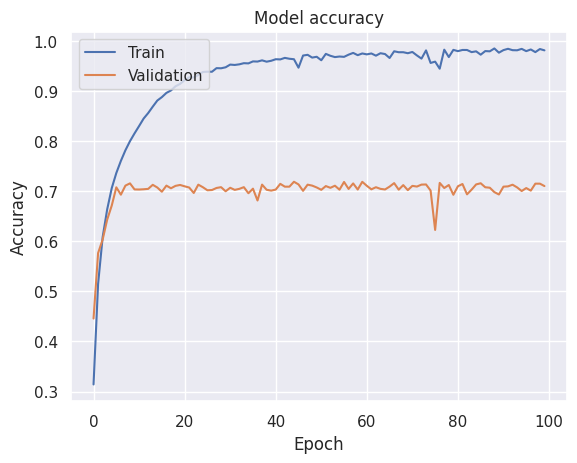

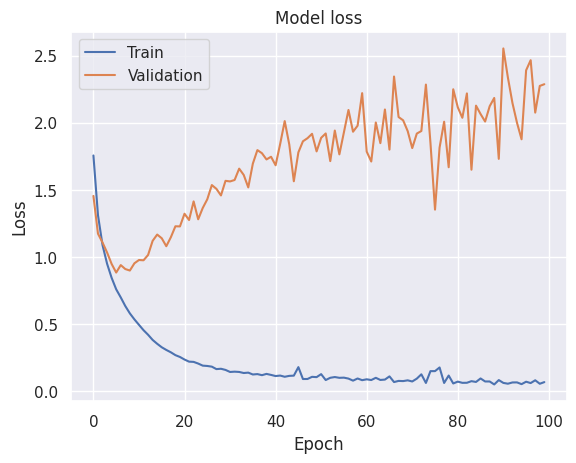

In [18]:
dense_model = create_dense_model(0.001,[32,64, 64, 128, 128, 256],[64, 128, 256, 128])
dense_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
dense_model, dense_history = train_model_cnn(dense_model, X_train, train_labels, X_val, val_labels, epochs=100, batch_size=32)
plot_training_history(dense_history)

In [19]:
# Performance on validation set
loss, accuracy, precision, recall= evaluate_model_cnn(dense_model, X_val, val_labels)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

313/313 [==============================] - 1s 2ms/step
Loss: 2.287558078765869
Accuracy: 0.7103000283241272
Precision: 0.7173080249776153
Recall: 0.7102999999999999


In [20]:
# Performance on Test set
dense_accuracy, dense_precision, dense_recall= metrics(dense_model, X_test, test_labels)

print(f"Dense Model Accuracy: {dense_accuracy}")
print(f"Dense Model Precision: {dense_precision}")
print(f"Dense Model Recall: {dense_recall}")

313/313 [==============================] - 1s 2ms/step
Dense Model Accuracy: 0.7104
Dense Model Precision: 0.7152174382624639
Dense Model Recall: 0.7103999999999999


In [13]:
# Adding regularization and dropout layers
from tensorflow.keras import regularizers
def create_dense_model_v2(learning_rate, num_filters, hidden_sizes, dropout_rate=0.3, l2_regularization=0.01):
    model = models.Sequential()
    for filter in num_filters:
        model.add(layers.Conv2D(filter, (3, 3), activation='relu', input_shape=(32, 32, 3), padding='same'))
        model.add(layers.MaxPooling2D((2, 2), padding='same'))
        model.add(layers.Dropout(dropout_rate))

    model.add(layers.Flatten())

    for hidden_size in hidden_sizes[1:-1]:
        model.add(layers.Dense(hidden_size, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(hidden_sizes[-1], activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    # L2 regularization on the dense layers
    for layer in model.layers:
        if isinstance(layer, layers.Dense):
            layer.kernel_regularizer = regularizers.l2(l2_regularization)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

Epoch 1/100
1250/1250 [==============================] - 27s 9ms/step - loss: 2.0817 - accuracy: 0.1952 - val_loss: 2.0655 - val_accuracy: 0.2314
Epoch 2/100
1250/1250 [==============================] - 11s 9ms/step - loss: 1.7609 - accuracy: 0.3232 - val_loss: 1.6690 - val_accuracy: 0.3769
Epoch 3/100
1250/1250 [==============================] - 13s 10ms/step - loss: 1.5827 - accuracy: 0.4002 - val_loss: 1.5913 - val_accuracy: 0.4213
Epoch 4/100
1250/1250 [==============================] - 10s 8ms/step - loss: 1.4597 - accuracy: 0.4573 - val_loss: 1.7506 - val_accuracy: 0.4236
Epoch 5/100
1250/1250 [==============================] - 12s 9ms/step - loss: 1.3867 - accuracy: 0.4934 - val_loss: 1.2286 - val_accuracy: 0.5438
Epoch 6/100
1250/1250 [==============================] - 10s 8ms/step - loss: 1.3122 - accuracy: 0.5259 - val_loss: 1.1344 - val_accuracy: 0.5897
Epoch 7/100
1250/1250 [==============================] - 10s 8ms/step - loss: 1.2633 - accuracy: 0.5457 - val_loss: 1.0532 

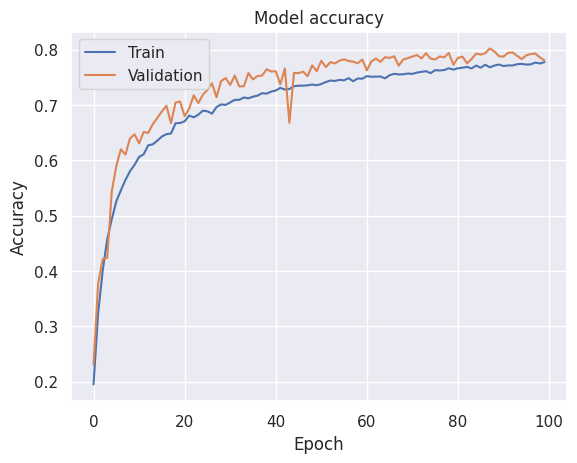

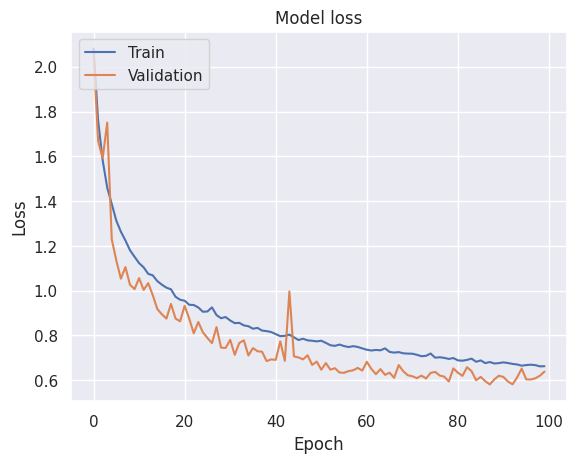

In [14]:
dense_model_v2 = create_dense_model_v2(0.001,[32,64, 64, 128, 128, 256],[64, 128, 256, 128])
dense_model_v2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
dense_model_v2, dense_history = train_model_cnn(dense_model_v2, X_train, train_labels, X_val, val_labels, epochs=100, batch_size=32)
plot_training_history(dense_history)

In [15]:
# Performance on validation set
loss, accuracy, precision, recall= evaluate_model_cnn(dense_model_v2, X_val, val_labels)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

313/313 [==============================] - 1s 2ms/step
Loss: 0.6381877660751343
Accuracy: 0.7803000211715698
Precision: 0.788521392863191
Recall: 0.7802999999999999


In [16]:
# Performance on test set
dense_accuracy_v2, dense_precision_v2, dense_recall_v2= metrics(dense_model_v2, X_test, test_labels)

print(f"Dense Model Accuracy: {dense_accuracy_v2}")
print(f"Dense Model Precision: {dense_precision_v2}")
print(f"Dense Model Recall: {dense_recall_v2}")

313/313 [==============================] - 1s 2ms/step
Dense Model Accuracy: 0.7749
Dense Model Precision: 0.7837311281552763
Dense Model Recall: 0.7748999999999999


In [ ]:
from itertools import product
import gc

def tuning(X_tr,y_tr, X_v, y_v, parameters):
  input_size = X_tr.shape[1]

  combinations = list(product(*parameters.values()))

  results = {}
  for iteration,combination in enumerate(combinations):
    print("Parameters - ",combination)
    lr = combination[0]
    filters = combination[1]
    hidden_sizes = combination[2]
    batch_size = combination[3]
    num_epochs = combination[4]
    model_train = create_dense_model_v2(lr, filters, hidden_sizes)
    model_train.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    trained_model, history = train_model_cnn(model=model_train, X_train=X_tr, y_train=y_tr,X_val=X_v, y_val=y_v, epochs=num_epochs, batch_size=batch_size)
    _, metric_accuracy, __, ___ = evaluate_model_cnn(trained_model,X_v, y_v)
    print("Accuracy - ",metric_accuracy)
    results[iteration] = {'num_filters':filters,
                          'hidden_sizes': hidden_sizes,
                          'learning_rate': lr,
                          'batch_size': batch_size,
                          'epochs': num_epochs,
                          'accuracy': metric_accuracy}
    del model_train
    del trained_model
    gc.collect()

  results = pd.DataFrame.from_dict(results, orient='index')
  best_combination = results[results['accuracy'] == results['accuracy'].max()]
  if len(best_combination)>1:
    parameters={}
    for combination in best_combination:
      parameters['num_filters']=combination['num_filters']
      parameters['hidden_sizes']=combination['hidden_sizes']
      parameters['learning_rate']=combination['learning_rate']
      parameters['batch_size']=combination['batch_size']
      parameters['epochs']=combination['epochs']
    return tuning(X_tr,y_tr, X_v, y_v, parameters)
  print("Tuning complete")
  return best_combination

In [ ]:
param_grid = {
    'learning_rate': [0.0001,0.001, 0.01,0.1],
    'num_filters': [[64,128,256,256,512],[32,64, 64, 128, 128, 256],[32, 64, 64, 128, 128, 256, 256]],
    'hidden_sizes':[[256,512,256],[64, 128, 256, 128]],
    'batch_size': [32,64],
    'num_epochs': [10]
}

best_combination = tuning(X_train,train_labels, X_val, val_labels, param_grid)

Parameters -  (0.0001, [64, 128, 256, 256, 512], [256, 512, 256], 32, 10)
Epoch 1/10
1250/1250 [==============================] - 14s 9ms/step - loss: 1.8847 - accuracy: 0.2909 - val_loss: 1.5285 - val_accuracy: 0.4281
Epoch 2/10
1250/1250 [==============================] - 11s 9ms/step - loss: 1.4245 - accuracy: 0.4764 - val_loss: 1.2383 - val_accuracy: 0.5441
Epoch 3/10
1250/1250 [==============================] - 11s 9ms/step - loss: 1.2335 - accuracy: 0.5563 - val_loss: 1.0646 - val_accuracy: 0.6169
Epoch 4/10
1250/1250 [==============================] - 11s 9ms/step - loss: 1.1126 - accuracy: 0.6048 - val_loss: 0.9946 - val_accuracy: 0.6402
Epoch 5/10
1250/1250 [==============================] - 11s 9ms/step - loss: 1.0308 - accuracy: 0.6317 - val_loss: 1.2751 - val_accuracy: 0.5790
Epoch 6/10
1250/1250 [==============================] - 11s 9ms/step - loss: 0.9603 - accuracy: 0.6657 - val_loss: 0.9036 - val_accuracy: 0.6875
Epoch 7/10
1250/1250 [==============================] - 

In [17]:
print(best_combination)

{'num_filters': [64, 128, 256, 256, 512], 'hidden_sizes': [256, 512, 256], 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10, 'accuracy': 0.7632}


Epoch 1/100
1250/1250 [==============================] - 16s 9ms/step - loss: 1.8546 - accuracy: 0.3101 - val_loss: 1.7139 - val_accuracy: 0.3726
Epoch 2/100
1250/1250 [==============================] - 11s 9ms/step - loss: 1.4368 - accuracy: 0.4739 - val_loss: 1.4197 - val_accuracy: 0.5055
Epoch 3/100
1250/1250 [==============================] - 11s 9ms/step - loss: 1.2602 - accuracy: 0.5439 - val_loss: 1.2363 - val_accuracy: 0.5695
Epoch 4/100
1250/1250 [==============================] - 11s 9ms/step - loss: 1.1308 - accuracy: 0.5952 - val_loss: 1.0732 - val_accuracy: 0.6193
Epoch 5/100
1250/1250 [==============================] - 11s 9ms/step - loss: 1.0412 - accuracy: 0.6338 - val_loss: 0.9906 - val_accuracy: 0.6519
Epoch 6/100
1250/1250 [==============================] - 11s 9ms/step - loss: 0.9751 - accuracy: 0.6584 - val_loss: 0.9522 - val_accuracy: 0.6626
Epoch 7/100
1250/1250 [==============================] - 11s 9ms/step - loss: 0.9073 - accuracy: 0.6833 - val_loss: 0.9521 -

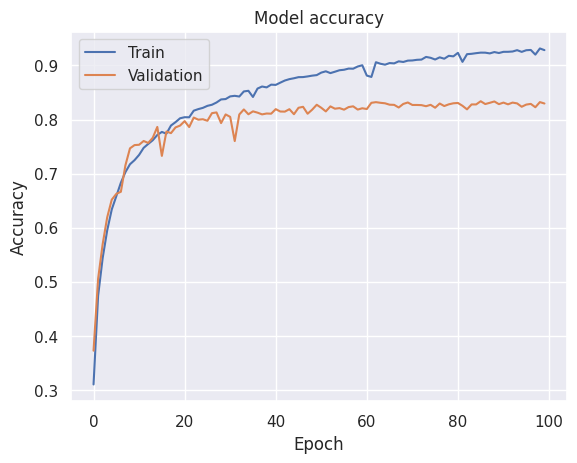

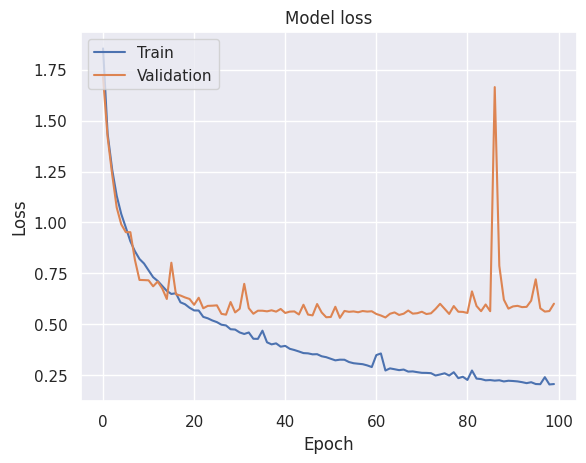

In [ ]:
# based on the tuned hyperparameters
dense_model_v2 = create_dense_model_v2(0.001,[64,128,256,256,512],[256,512,256])
dense_model_v2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
dense_model_v2, dense_history = train_model_cnn(dense_model_v2, X_train, train_labels, X_val, val_labels, epochs=100, batch_size=32)
plot_training_history(dense_history)

In [ ]:
# Performance of tuned hyperparameter model on validation set
loss, accuracy, precision, recall= evaluate_model_cnn(dense_model_v2, X_val, val_labels)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

313/313 [==============================] - 1s 3ms/step
Loss: 0.6009288430213928
Accuracy: 0.8296999931335449
Precision: 0.8320696171836695
Recall: 0.8297000000000001


In [ ]:
# Performance of tuned hyperparameter model on test set
dense_accuracy_v2, dense_precision_v2, dense_recall_v2= metrics(dense_model_v2, X_test, test_labels)

print(f"Dense Model Accuracy: {dense_accuracy_v2}")
print(f"Dense Model Precision: {dense_precision_v2}")
print(f"Dense Model Recall: {dense_recall_v2}")

313/313 [==============================] - 1s 3ms/step
Dense Model Accuracy: 0.8295
Dense Model Precision: 0.8290118147690955
Dense Model Recall: 0.8295


In [ ]:
def load_cifar10_data(resize=False,resize_values=None):
    if resize:
      transform = transforms.Compose([transforms.Resize(resize_values),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    else:
      transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    valset, trainset = torch.utils.data.random_split(trainset, [5000, len(trainset) - 5000])
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    valloader = torch.utils.data.DataLoader(valset, batch_size=128, shuffle=False, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

    return trainloader, valloader, testloader

In [ ]:
# Define the model training function
def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=10):
    train_loss_history = []
    val_loss_history = []
    train_accuracy_history = []
    val_accuracy_history = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_accuracy = 100.0 * correct_train / total_train

        model.eval()
        val_loss,val_accuracy = evaluate_model(model, valloader, criterion)

        if epoch%10==9:
          print(f'Epoch {epoch+1}/{num_epochs}:')
          print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
          print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        train_accuracy_history.append(train_accuracy)
        val_accuracy_history.append(val_accuracy)

    return model, train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history

In [ ]:
# Define the evaluation functions
def evaluate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return running_loss / len(dataloader),100.0 * correct / total

def evaluate_accuracy(model, dataloader):
    model.eval()

    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.to('cuda:0'))
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(outputs.argmax(dim=1).cpu().numpy())
    precision = precision_score(true_labels, predicted_labels,average='macro',zero_division=0.0)
    recall = recall_score(true_labels, predicted_labels,average='macro',zero_division=0.0)
    accuracy = accuracy_score(true_labels,predicted_labels)

    return accuracy,precision,recall

In [ ]:
from sklearn.utils.multiclass import unique_labels

# Define a function to plot loss and accuracy
def plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='Train Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.title('Accuracy')

    plt.show()

100%|██████████| 170498071/170498071 [00:12<00:00, 13965545.75it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 10/100:
Train Loss: 1.0059, Train Accuracy: 63.81%
Validation Loss: 1.0170, Validation Accuracy: 63.24%
Epoch 20/100:
Train Loss: 0.3810, Train Accuracy: 86.41%
Validation Loss: 0.9146, Validation Accuracy: 72.84%
Epoch 30/100:
Train Loss: 0.0650, Train Accuracy: 97.80%
Validation Loss: 1.4899, Validation Accuracy: 71.80%
Epoch 40/100:
Train Loss: 0.0194, Train Accuracy: 99.40%
Validation Loss: 1.7156, Validation Accuracy: 74.34%
Epoch 50/100:
Train Loss: 0.0001, Train Accuracy: 100.00%
Validation Loss: 2.0565, Validation Accuracy: 76.08%
Epoch 60/100:
Train Loss: 0.0001, Train Accuracy: 100.00%
Validation Loss: 2.1742, Validation Accuracy: 76.06%
Epoch 70/100:
Train Loss: 0.0000, Train Accuracy: 100.00%
Validation Loss: 2.2620, Validation Accuracy: 76.14%
Epoch 80/100:
Train Loss: 0.0000, Train Accuracy: 100.00%
Validation Loss: 2.3040, Validation Accuracy: 76.40%
Epoch 90/100:
Train Loss: 0.0000, Train Accuracy: 100.00%
Validation Loss: 2.3362, Validation Accuracy: 76.14%
Epoch

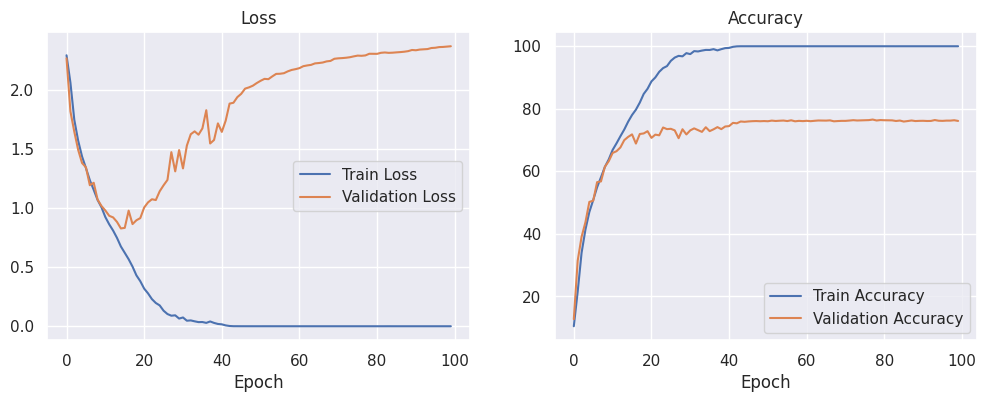

In [ ]:
# Setting the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loading CIFAR-10 data with validation set
trainloader, valloader, testloader = load_cifar10_data()

# Defining and training VGG11
vgg11 = torchvision.models.vgg11(pretrained=False, num_classes=10)
vgg11.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg11.parameters(), lr=0.001, momentum=0.9)
vgg11, vgg11_train_loss, vgg11_val_loss, vgg11_train_accuracy, vgg11_val_accuracy = train_model(vgg11, trainloader, valloader, criterion, optimizer, num_epochs=100)

# Plot loss and accuracy for VGG11
plot_loss_accuracy(vgg11_train_loss, vgg11_val_loss, vgg11_train_accuracy, vgg11_val_accuracy)

In [ ]:
# evaluating metrics
accuracy,precision,recall = evaluate_accuracy(vgg11,testloader)
print("Accuracy on testset: ",accuracy)
print("Precision on testset: ",precision)
print("Recall on testset: ",recall)

Accuracy on testset:  0.7566
Precision on testset:  0.7572867891188284
Recall on testset:  0.7565999999999999


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 10/100:
Train Loss: 1.6599, Train Accuracy: 38.78%
Validation Loss: 1.6482, Validation Accuracy: 41.20%
Epoch 20/100:
Train Loss: 1.1469, Train Accuracy: 59.04%
Validation Loss: 1.1286, Validation Accuracy: 60.94%
Epoch 30/100:
Train Loss: 0.8078, Train Accuracy: 71.64%
Validation Loss: 0.8754, Validation Accuracy: 70.66%
Epoch 40/100:
Train Loss: 0.5834, Train Accuracy: 79.65%
Validation Loss: 0.6480, Validation Accuracy: 77.98%
Epoch 50/100:
Train Loss: 0.4163, Train Accuracy: 85.26%
Validation Loss: 0.5967, Validation Accuracy: 80.64%
Epoch 60/100:
Train Loss: 0.2892, Train Accuracy: 89.70%
Validation Loss: 0.5518, Validation Accuracy: 82.26%
Epoch 70/100:
Train Loss: 0.1814, Train Accuracy: 93.53%
Validation Loss: 0.6123, Validation Accuracy: 82.18%
Epoch 80/100:
Train Loss: 0.1151, Train Accuracy: 95.83%
Validation Loss: 0.6191, Validation Accuracy: 83.04%
Epoch 90/100:
Train Loss: 0.0736, Train Accuracy: 97.44%
Validation Loss: 0.6184, Validation Accuracy: 83.88%
Epoch 100/

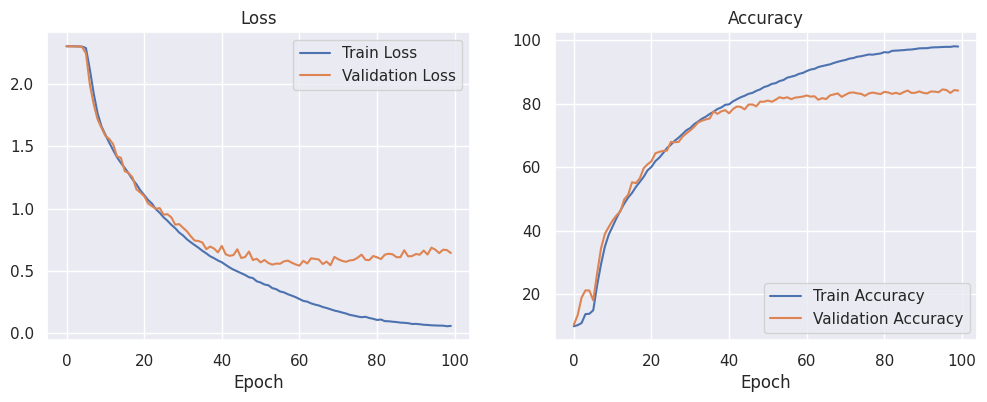

In [ ]:
trainloader_AN, valloader_AN, testloader_AN = load_cifar10_data(resize=True,resize_values=(224, 224))
# Defining and training AlexNet
alexnet = torchvision.models.alexnet(pretrained=False, num_classes=10)
alexnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)
alexnet, alexnet_train_loss, alexnet_val_loss, alexnet_train_accuracy, alexnet_val_accuracy = train_model(alexnet, trainloader_AN, valloader_AN, criterion, optimizer, num_epochs=100)

# Plot loss and accuracy for AlexNet
plot_loss_accuracy(alexnet_train_loss, alexnet_val_loss, alexnet_train_accuracy, alexnet_val_accuracy)

In [ ]:
# measuring the metrcis
accuracy,precision,recall = evaluate_accuracy(alexnet,testloader_AN)
print("Accuracy on testset: ",accuracy)
print("Precision on testset: ",precision)
print("Recall on testset: ",recall)

Accuracy on testset:  0.835
Precision on testset:  0.836441283647727
Recall on testset:  0.835


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 10/100:
Train Loss: 0.2559, Train Accuracy: 90.90%
Validation Loss: 1.1425, Validation Accuracy: 69.98%
Epoch 20/100:
Train Loss: 0.0856, Train Accuracy: 96.97%
Validation Loss: 1.3241, Validation Accuracy: 71.62%
Epoch 30/100:
Train Loss: 0.0512, Train Accuracy: 98.26%
Validation Loss: 1.4194, Validation Accuracy: 72.36%
Epoch 40/100:
Train Loss: 0.0669, Train Accuracy: 97.74%
Validation Loss: 1.4679, Validation Accuracy: 71.88%
Epoch 50/100:
Train Loss: 0.0527, Train Accuracy: 98.12%
Validation Loss: 1.3822, Validation Accuracy: 72.16%
Epoch 60/100:
Train Loss: 0.0419, Train Accuracy: 98.52%
Validation Loss: 1.3499, Validation Accuracy: 72.80%
Epoch 70/100:
Train Loss: 0.0442, Train Accuracy: 98.55%
Validation Loss: 1.3527, Validation Accuracy: 72.26%
Epoch 80/100:
Train Loss: 0.0480, Train Accuracy: 98.47%
Validation Loss: 1.2909, Validation Accuracy: 72.26%
Epoch 90/100:
Train Loss: 0.0401, Train Accuracy: 98.67%
Validation Loss: 1.3316, Validation Accuracy: 72.36%
Epoch 100/

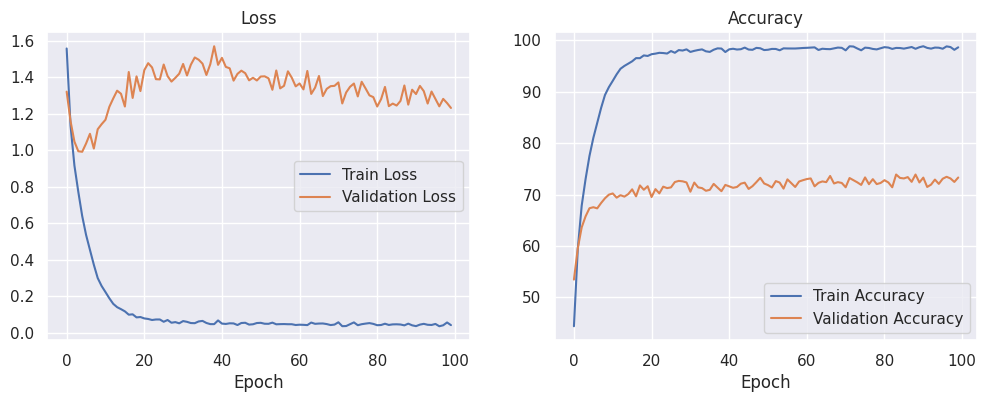

In [ ]:
# Defining and training ResNet-18
resnet18 = torchvision.models.resnet18(pretrained=False, num_classes=10)  # Pre-trained models for CIFAR-10 have 10 output classes
resnet18.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
resnet18, resnet18_train_loss, resnet18_val_loss, resnet18_train_accuracy, resnet18_val_accuracy = train_model(resnet18, trainloader, valloader, criterion, optimizer, num_epochs=100)

# Plot loss and accuracy for ResNet-18
plot_loss_accuracy(resnet18_train_loss, resnet18_val_loss, resnet18_train_accuracy, resnet18_val_accuracy)

In [ ]:
# measuring the metrics
accuracy,precision,recall = evaluate_accuracy(resnet18,testloader)
print("Accuracy on testset: ",accuracy)
print("Precision on testset: ",precision)
print("Recall on testset: ",recall)

Accuracy on testset:  0.743
Precision on testset:  0.7415739640317506
Recall on testset:  0.743
